In [65]:
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

### Importando Dados

In [3]:
train_df = pd.read_csv('data/train_processed.csv')
test_df = pd.read_csv('data/test_processed.csv')

# dividindo os dados em 50% treinamento, 25% validacao, 25% teste
train_data, val_data = train_test_split(train_df, test_size=0.25, random_state=42)

In [3]:
train_df.head(10)

,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,...,Arrival Delay in Minutes,Jovem,Adulto,Idoso,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,0.086632,0.6,0.8,0.6,0.2,1.0,0.6,1.0,1.0,0.8,...,0.56250,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.041195,0.6,0.4,0.6,0.6,0.2,0.6,0.2,0.2,0.2,...,0.18750,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.224354,0.4,0.4,0.4,0.4,1.0,1.0,1.0,1.0,0.8,...,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.107229,0.4,1.0,1.0,1.0,0.4,0.4,0.4,0.4,0.4,...,0.28125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.036955,0.6,0.6,0.6,0.6,0.8,1.0,1.0,0.6,0.6,...,0.00000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,0.232027,0.6,0.8,0.4,0.2,0.2,0.4,0.2,0.2,0.6,...,0.00000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6,0.251414,0.4,0.8,0.4,0.6,0.4,0.4,0.4,0.4,0.6,...,0.71875,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
7,0.404685,0.8,0.6,0.8,0.8,1.0,1.0,1.0,1.0,1.0,...,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.165994,0.2,0.4,0.4,0.4,0.8,0.6,0.6,0.2,0.2,...,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.207997,0.6,0.6,0.6,0.8,0.4,0.6,0.6,0.4,0.4,...,0.00000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [4]:
train_df.dtypes

Flight Distance                      float64
Inflight wifi service                float64
Departure/Arrival time convenient    float64
Ease of Online booking               float64
Gate location                        float64
Food and drink                       float64
Online boarding                      float64
Seat comfort                         float64
Inflight entertainment               float64
On-board service                     float64
Leg room service                     float64
Baggage handling                     float64
Checkin service                      float64
Inflight service                     float64
Cleanliness                          float64
Departure Delay in Minutes           float64
Arrival Delay in Minutes             float64
Jovem                                float64
Adulto                               float64
Idoso                                float64
Gender_Male                          float64
Customer Type_disloyal Customer      float64
Type of Tr

### Criando os Datasets e DataLoaders

In [4]:
# classe para criar os datasets
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = row[:-1].values.astype('float32')
        label = row[-1].astype('int64')

        features = torch.tensor(features)
        label = torch.tensor(label)

        return features, label

In [5]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_df)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # shuffle = true para os dados serem acessados aleatoriamente
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [6]:
# utilizar a gpu para treinar
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

### Funcoes auxiliares

In [7]:
# registrar os custos
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
# treinamento de uma epoca
def train_step(model, train_dl, criterion, optimizer, device):
    model.train()

    train_loss = AverageMeter()
    for instances, labels in train_dl:
        # mover os dados para o device e fazer as previsoes
        instances = instances.to(device)
        labels = labels.to(device)
        logits = model(instances)

        # zerar os gradientes
        optimizer.zero_grad()

        # calcular o erro
        loss = criterion(logits, labels)
        train_loss.update(loss.item(), len(instances))

        # calcular os gradientes e atualizar os pesos
        loss.backward()
        optimizer.step()
    
    return train_loss.avg

In [9]:
# validacao
def validation_step(model, val_dl, criterion, device):
    model.eval()

    val_loss = AverageMeter()
    for instances, labels in val_dl:
        instances = instances.to(device)
        labels = labels.to(device)

        logits = model(instances)
        loss = criterion(logits, labels)

        val_loss.update(loss.item(), len(instances))

    return val_loss.avg

In [10]:
def train(model, train_dl, val_dl, criterion, optimizer, device, epochs):
    loss = {
        "train_loss": [],
        "val_loss": []
    }
    
    # para printar as épocas apenas 5 vezes, durante o treinamento
    print_epochs = epochs // 5

    for epoch in range(1, epochs+1):
        train_loss = train_step(model, train_dl, criterion, optimizer, device)
        val_loss = validation_step(model, val_dl, criterion, device)

        loss["train_loss"].append(train_loss)
        loss["val_loss"].append(val_loss)

        if (epoch % print_epochs) == 0:
            print(f"Train loss: {round(train_loss, 6):<7}")
            print(f"Valid. loss: {round(val_loss, 6):<7}\n")

    # mostrar apenas 30 valores de loss, para a escala do gráfico não ficar muito pequena
    update_graph = epochs//30
    if update_graph < 1:
        update_graph = 1

    # plotar o gráfico de loss
    fig = plt.figure()
    plt.title("Cross entropy loss")
    plt.plot(loss["train_loss"][::update_graph], c="g", label="train")
    plt.plot(loss["val_loss"][::update_graph], c="r", label="valid")
    plt.legend()

In [11]:
def test(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        # mover os dados para a gpu
        instances = instances.to(device)
        labels = labels.to(device)

        # fazer as previsões
        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        total_corrects += (preds == labels).sum().item()
        total_n += len(instances)

        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())
        all_probs.append(probabilities.cpu())


    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    labels = list(str(i) for i in range(2))
    # métricas
    print(classification_report(targets, preds, target_names=labels, zero_division=0, digits=4))

    return total_corrects/total_n

### Classe da arquitetura


In [12]:
class MLP(nn.Module):
    def __init__(self, architecture):
        super(MLP, self).__init__()
        mlp_input_size = architecture['input_size']

        self.fc_layers = nn.ModuleList()
        
        # podemos passar 'n' camadas personalizadas, especificando a quantidade de neurônios,
        # a função de ativação e dropout com uma probabilidade dada
        for units in architecture['mlp']:
            self.fc_layers.append(nn.Linear(mlp_input_size, units['out_units']))
            if 'activation' in units:
                self.fc_layers.append(units['activation']())
            if 'dropout' in units:
                self.fc_layers.append(nn.Dropout(units['dropout']))
            mlp_input_size = units['out_units']

        self.output_layer = nn.Linear(mlp_input_size, architecture['output_units'])

    def forward(self, X):
        for layer in self.fc_layers:
            X = layer(X)
        
        X = self.output_layer(X)
        return X

In [13]:
def hyperparameter_search(train_dl, val_dl, test_dl, param_grid, device):
    best_accuracy = 0
    best_model = None
    loss_fn = nn.CrossEntropyLoss()

    i = 1
    total = len(ParameterGrid(param_grid))
    for params in ParameterGrid(param_grid):
        print(f"Parameter set {i}/{total}")
        print(f"Testing with parameters: {params}")

        model = MLP(params['architecture']).to(device)

        # hiperparametros como otimizador, learning rate e número de épocas são passados como entrada
        optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])

        train(model, train_dl, val_dl, loss_fn, optimizer, device, params['epochs'])
        val_accuracy = test(model, test_dl, device)

        # salvar quais foram os parâmetros que deram melhor acurácia
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
        i += 1

    return best_model, best_accuracy

### Testando otimizadores

Aqui testaremos diferentes otimizadores (Adam, Adadelta e RMSprop) com vários valores de épocas (15, 30 e 45) e learning rate (10^-3 e 10^-4). Todos esses testes são feitos numa arquitetura com 1 camada de 16 neurônios, com função de ativação ReLU.

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.200439
Valid. loss: 0.191844

Train loss: 0.170814
Valid. loss: 0.164654

Train loss: 0.157765
Valid. loss: 0.156417

Train loss: 0.14966
Valid. loss: 0.147004

Train loss: 0.144518
Valid. loss: 0.142709

              precision    recall  f1-score   support

           0     0.9415    0.9568    0.9491     14573
           1     0.9436    0.9240    0.9337     11403

    accuracy                         0.9424     25976
   macro avg     0.9425    0.9404    0.9414     25976
weighted avg     0.9424    0.9424    0.9423     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.686845
Valid. loss: 0.683182

Train loss: 0.66387
Valid. loss: 0.659867

Train loss: 0.638533
Valid. loss: 0.634746

Train loss: 0.612618
Valid. loss: 0.608671

Train loss: 0.585253
Valid. loss: 0.581252

              precision    recall  f1-score   support

           0     0.8015    0.8206    0.8110     14573
           1     0.7636    0.7403    0.7518     11403

    accuracy                         0.7854     25976
   macro avg     0.7826    0.7805    0.7814     25976
weighted avg     0.7849    0.7854    0.7850     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.193234
Valid. loss: 0.182382

Train loss: 0.149349
Valid. loss: 0.144881

Train loss: 0.13732
Valid. loss: 0.144997

Train loss: 0.132543
Valid. loss: 0.149841

Train loss: 0.129658
Valid. loss: 0.127689

              precision    recall  f1-score   support

           0     0.9360    0.9646    0.9501     14573
           1     0.9529    0.9157    0.9339     11403

    accuracy                         0.9431     25976
   macro avg     0.9445    0.9402    0.9420     25976
weighted avg     0.9434    0.9431    0.9430     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.0001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.352705
Valid. loss: 0.342502

Train loss: 0.302739
Valid. loss: 0.294762

Train loss: 0.257764
Valid. loss: 0.252117

Train loss: 0.227981
Valid. loss: 0.224872

Train loss: 0.210653
Valid. loss: 0.209363

              precision    recall  f1-score   support

           0     0.8858    0.9532    0.9183     14573
           1     0.9337    0.8429    0.8860     11403

    accuracy                         0.9048     25976
   macro avg     0.9098    0.8981    0.9021     25976
weighted avg     0.9068    0.9048    0.9041     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.0001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.72517
Valid. loss: 0.723347

Train loss: 0.720531
Valid. loss: 0.718854

Train loss: 0.716258
Valid. loss: 0.714725

Train loss: 0.71236
Valid. loss: 0.710957

Train loss: 0.708788
Valid. loss: 0.707494

              precision    recall  f1-score   support

           0     0.8980    0.0060    0.0120     14573
           1     0.4403    0.9991    0.6112     11403

    accuracy                         0.4420     25976
   macro avg     0.6691    0.5026    0.3116     25976
weighted avg     0.6970    0.4420    0.2750     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.0001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.37141
Valid. loss: 0.358968

Train loss: 0.317867
Valid. loss: 0.307937

Train loss: 0.267232
Valid. loss: 0.260285

Train loss: 0.233798
Valid. loss: 0.229731

Train loss: 0.213474
Valid. loss: 0.210775

              precision    recall  f1-score   support

           0     0.8954    0.9435    0.9188     14573
           1     0.9224    0.8592    0.8897     11403

    accuracy                         0.9065     25976
   macro avg     0.9089    0.9013    0.9042     25976
weighted avg     0.9073    0.9065    0.9060     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.168082
Valid. loss: 0.169043

Train loss: 0.149186
Valid. loss: 0.145612

Train loss: 0.143405
Valid. loss: 0.14023

Train loss: 0.139977
Valid. loss: 0.136598

Train loss: 0.13732
Valid. loss: 0.134903

              precision    recall  f1-score   support

           0     0.9166    0.9695    0.9423     14573
           1     0.9579    0.8872    0.9212     11403

    accuracy                         0.9334     25976
   macro avg     0.9372    0.9283    0.9317     25976
weighted avg     0.9347    0.9334    0.9330     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.66165
Valid. loss: 0.656122

Train loss: 0.596589
Valid. loss: 0.591693

Train loss: 0.532761
Valid. loss: 0.52825

Train loss: 0.479271
Valid. loss: 0.475961

Train loss: 0.4417 
Valid. loss: 0.439559

              precision    recall  f1-score   support

           0     0.8180    0.8445    0.8310     14573
           1     0.7927    0.7598    0.7759     11403

    accuracy                         0.8073     25976
   macro avg     0.8053    0.8022    0.8035     25976
weighted avg     0.8069    0.8073    0.8068     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.185728
Valid. loss: 0.194499

Train loss: 0.156214
Valid. loss: 0.150694

Train loss: 0.144889
Valid. loss: 0.139966

Train loss: 0.137917
Valid. loss: 0.137828

Train loss: 0.132927
Valid. loss: 0.1331 

              precision    recall  f1-score   support

           0     0.9458    0.9538    0.9497     14573
           1     0.9402    0.9301    0.9351     11403

    accuracy                         0.9434     25976
   macro avg     0.9430    0.9419    0.9424     25976
weighted avg     0.9433    0.9434    0.9433     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.314301
Valid. loss: 0.307905

Train loss: 0.2477 
Valid. loss: 0.243361

Train loss: 0.211647
Valid. loss: 0.210042

Train loss: 0.19071
Valid. loss: 0.189446

Train loss: 0.176116
Valid. loss: 0.175843

              precision    recall  f1-score   support

           0     0.9194    0.9459    0.9325     14573
           1     0.9283    0.8941    0.9108     11403

    accuracy                         0.9232     25976
   macro avg     0.9238    0.9200    0.9217     25976
weighted avg     0.9233    0.9232    0.9230     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.694991
Valid. loss: 0.693651

Train loss: 0.687393
Valid. loss: 0.686262

Train loss: 0.680364
Valid. loss: 0.679425

Train loss: 0.67375
Valid. loss: 0.672951

Train loss: 0.667415
Valid. loss: 0.666731

              precision    recall  f1-score   support

           0     0.7951    0.6443    0.7118     14573
           1     0.6341    0.7878    0.7026     11403

    accuracy                         0.7073     25976
   macro avg     0.7146    0.7160    0.7072     25976
weighted avg     0.7244    0.7073    0.7078     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.323956
Valid. loss: 0.319002

Train loss: 0.277917
Valid. loss: 0.272204

Train loss: 0.237034
Valid. loss: 0.233229

Train loss: 0.21084
Valid. loss: 0.207705

Train loss: 0.196125
Valid. loss: 0.194012

              precision    recall  f1-score   support

           0     0.8979    0.9586    0.9273     14573
           1     0.9421    0.8607    0.8996     11403

    accuracy                         0.9157     25976
   macro avg     0.9200    0.9097    0.9134     25976
weighted avg     0.9173    0.9157    0.9151     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.152318
Valid. loss: 0.152223

Train loss: 0.140108
Valid. loss: 0.139147

Train loss: 0.133856
Valid. loss: 0.134808

Train loss: 0.130068
Valid. loss: 0.127357

Train loss: 0.128153
Valid. loss: 0.127335

              precision    recall  f1-score   support

           0     0.9319    0.9717    0.9514     14573
           1     0.9618    0.9092    0.9348     11403

    accuracy                         0.9443     25976
   macro avg     0.9468    0.9405    0.9431     25976
weighted avg     0.9450    0.9443    0.9441     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.609712
Valid. loss: 0.606335

Train loss: 0.531049
Valid. loss: 0.527831

Train loss: 0.465724
Valid. loss: 0.463914

Train loss: 0.426026
Valid. loss: 0.425276

Train loss: 0.40371
Valid. loss: 0.403349

              precision    recall  f1-score   support

           0     0.8233    0.8551    0.8389     14573
           1     0.8052    0.7654    0.7848     11403

    accuracy                         0.8158     25976
   macro avg     0.8143    0.8103    0.8119     25976
weighted avg     0.8154    0.8158    0.8152     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.21551
Valid. loss: 0.209947

Train loss: 0.161616
Valid. loss: 0.168905

Train loss: 0.144462
Valid. loss: 0.144394

Train loss: 0.135215
Valid. loss: 0.138071

Train loss: 0.125363
Valid. loss: 0.125143

              precision    recall  f1-score   support

           0     0.9313    0.9710    0.9507     14573
           1     0.9608    0.9085    0.9339     11403

    accuracy                         0.9436     25976
   macro avg     0.9461    0.9398    0.9423     25976
weighted avg     0.9443    0.9436    0.9434     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.0001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.275243
Valid. loss: 0.270492

Train loss: 0.230784
Valid. loss: 0.228933

Train loss: 0.207385
Valid. loss: 0.205654

Train loss: 0.183559
Valid. loss: 0.181587

Train loss: 0.169763
Valid. loss: 0.16817

              precision    recall  f1-score   support

           0     0.9123    0.9559    0.9336     14573
           1     0.9400    0.8825    0.9103     11403

    accuracy                         0.9237     25976
   macro avg     0.9261    0.9192    0.9220     25976
weighted avg     0.9244    0.9237    0.9234     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.0001, 'optimizer': 'Adadelta'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.715516
Valid. loss: 0.714384

Train loss: 0.700285
Valid. loss: 0.699275

Train loss: 0.686686
Valid. loss: 0.68589

Train loss: 0.675045
Valid. loss: 0.674486

Train loss: 0.664854
Valid. loss: 0.664462

              precision    recall  f1-score   support

           0     0.6754    0.8364    0.7473     14573
           1     0.6993    0.4863    0.5737     11403

    accuracy                         0.6827     25976
   macro avg     0.6874    0.6613    0.6605     25976
weighted avg     0.6859    0.6827    0.6711     25976

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.0001, 'optimizer': 'RMSprop'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_2801/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.273484
Valid. loss: 0.267012

Train loss: 0.205786
Valid. loss: 0.203578

Train loss: 0.17984
Valid. loss: 0.178223

Train loss: 0.16521
Valid. loss: 0.163824

Train loss: 0.155387
Valid. loss: 0.154969

              precision    recall  f1-score   support

           0     0.9266    0.9526    0.9394     14573
           1     0.9372    0.9036    0.9201     11403

    accuracy                         0.9311     25976
   macro avg     0.9319    0.9281    0.9298     25976
weighted avg     0.9313    0.9311    0.9309     25976

Best parameters: <generator object Module.parameters at 0x304a435a0>
Best validation accuracy: 0.9443


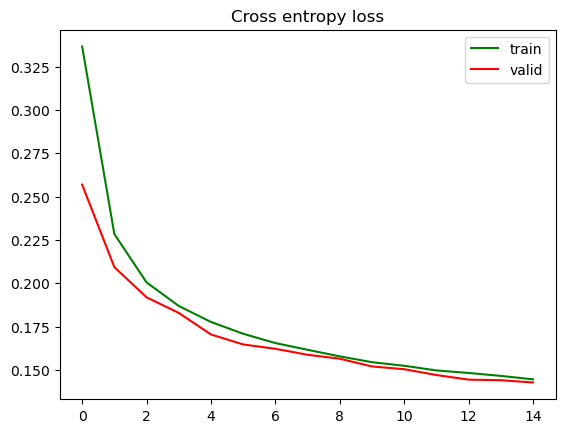

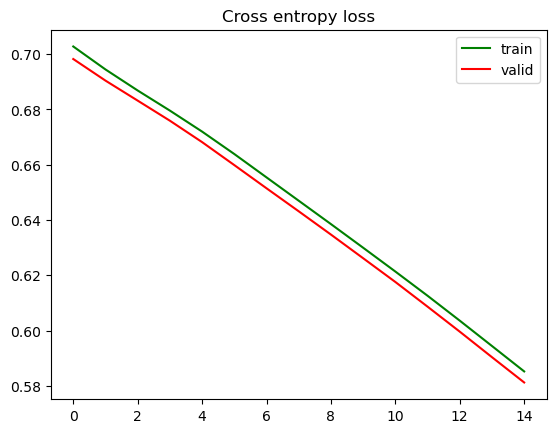

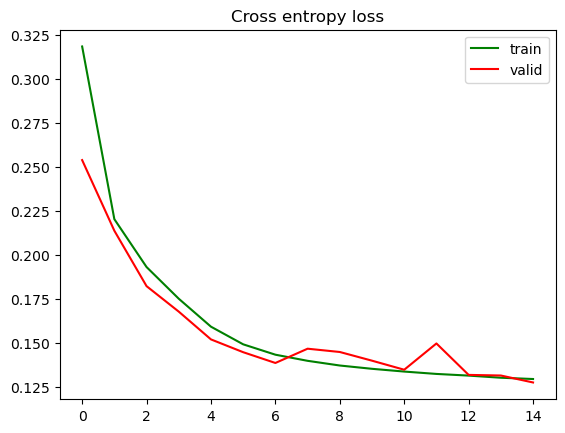

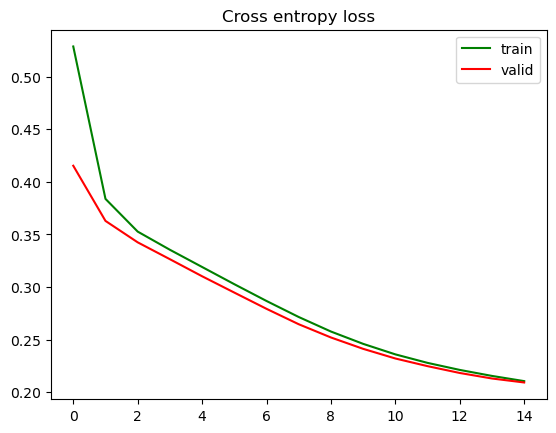

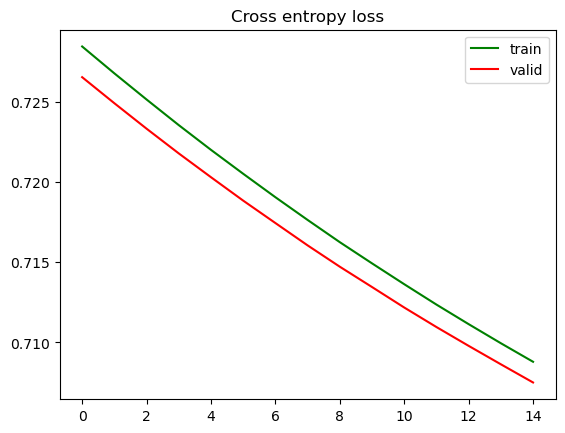

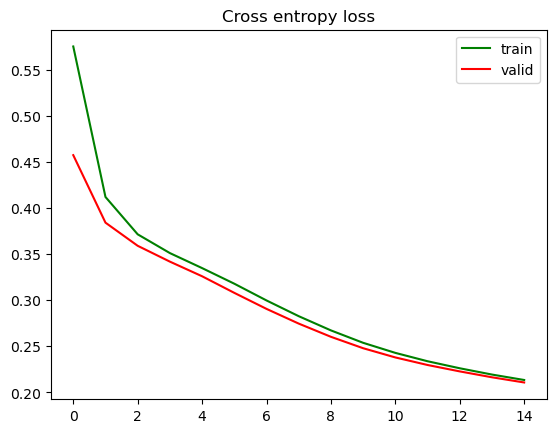

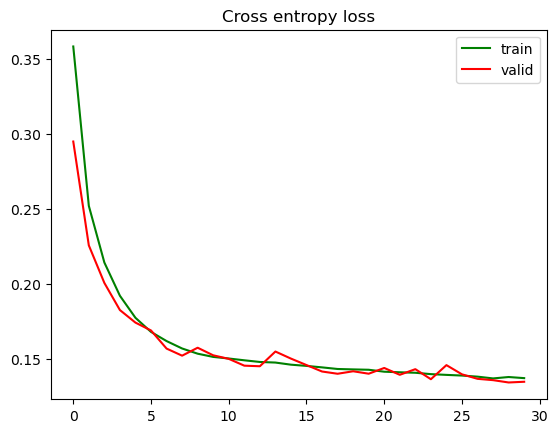

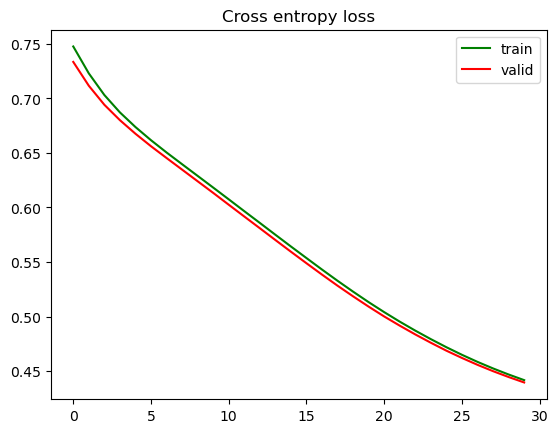

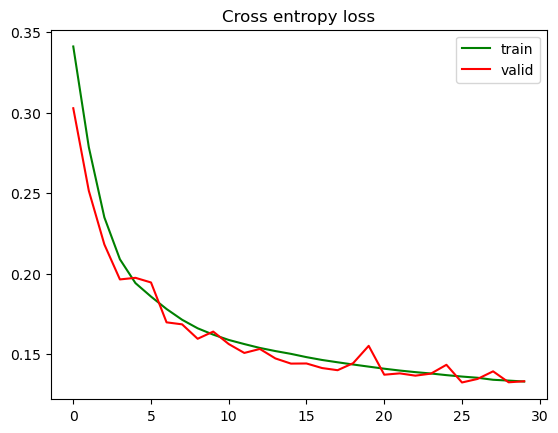

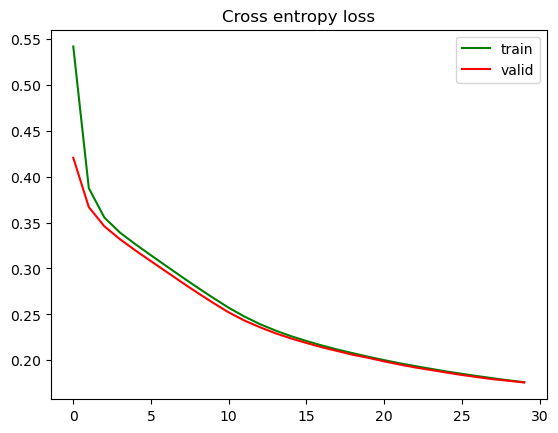

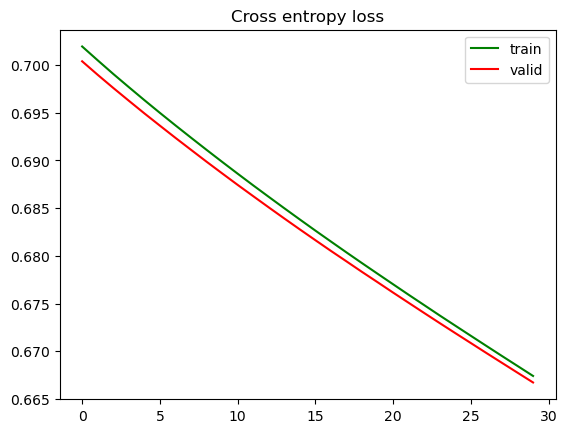

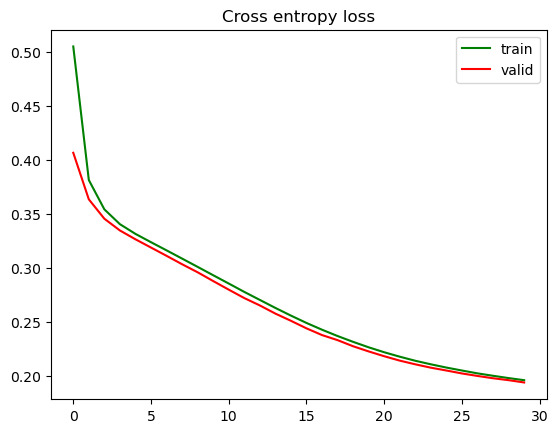

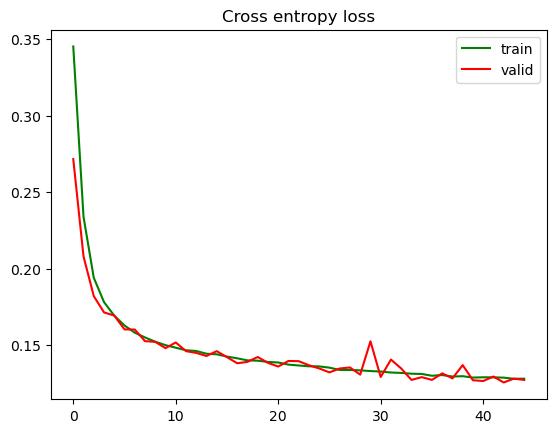

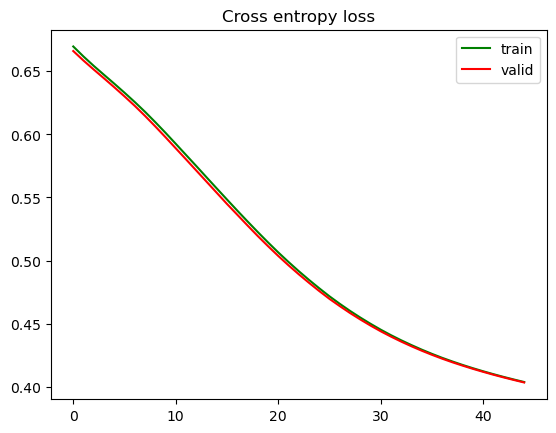

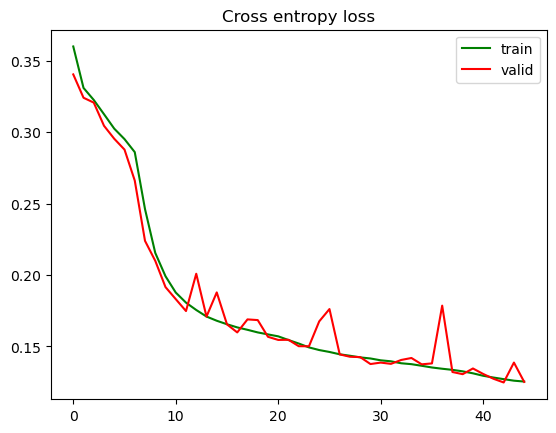

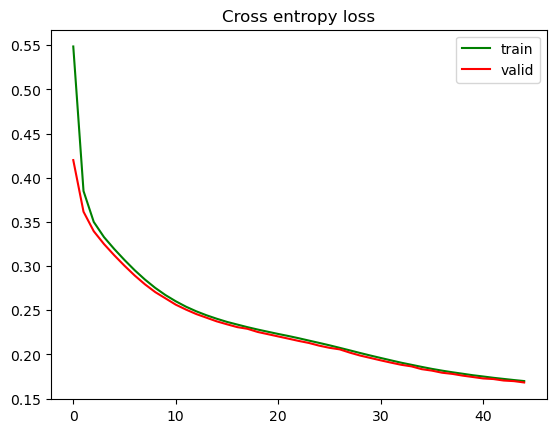

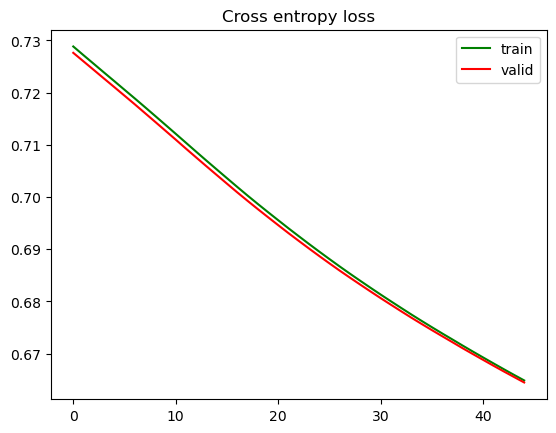

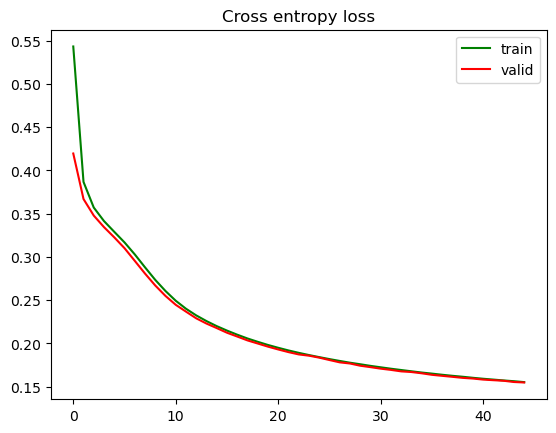

In [14]:
param_grid = {
    'architecture': [
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 16, 'activation': nn.ReLU}
            ],
            'output_units': 2
        }
    ],
    'learning_rate': [0.001, 0.0001],
    'optimizer': ['Adam', 'Adadelta', 'RMSprop'],
    'epochs': [15, 30, 45]
}

best_model, best_accuracy = hyperparameter_search(train_loader, val_loader, test_loader, param_grid, device)
print(f"Best parameters: {best_model.parameters()}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Melhor resultado (com 1 camada oculta com 16 unidades e relu):
- Adam, LR 1e-3, 45 épocas (94.43% de acurácia)

### Testando diferentes funções de ativação

Aqui testamos diferentes funções de ativação: ReLU, Sigmoid e Tanh. Em todos esses testes utilizamos a mesma arquitetura, 2 camadas com 16 unidades, com LR de 10^-3, Adam e 45 épocas.

Parameter set 1/3
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'out_units': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.137233
Valid. loss: 0.135196

Train loss: 0.121194
Valid. loss: 0.119275

Train loss: 0.112447
Valid. loss: 0.108993

Train loss: 0.10587
Valid. loss: 0.108595

Train loss: 0.102961
Valid. loss: 0.103006

              precision    recall  f1-score   support

           0     0.9451    0.9737    0.9592     14573
           1     0.9651    0.9277    0.9460     11403

    accuracy                         0.9535     25976
   macro avg     0.9551    0.9507    0.9526     25976
weighted avg     0.9538    0.9535    0.9534     25976

Parameter set 2/3
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}, {'out_units': 16, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.286281
Valid. loss: 0.278182

Train loss: 0.166846
Valid. loss: 0.163022

Train loss: 0.148913
Valid. loss: 0.148331

Train loss: 0.141998
Valid. loss: 0.139335

Train loss: 0.135876
Valid. loss: 0.136763

              precision    recall  f1-score   support

           0     0.9208    0.9741    0.9467     14573
           1     0.9642    0.8929    0.9272     11403

    accuracy                         0.9384     25976
   macro avg     0.9425    0.9335    0.9369     25976
weighted avg     0.9399    0.9384    0.9381     25976

Parameter set 3/3
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 16, 'activation': <class 'torch.nn.modules.activation.Tanh'>}, {'out_units': 16, 'activation': <class 'torch.nn.modules.activation.Tanh'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.148875
Valid. loss: 0.150248

Train loss: 0.122068
Valid. loss: 0.119381

Train loss: 0.111064
Valid. loss: 0.111347

Train loss: 0.106842
Valid. loss: 0.116845

Train loss: 0.103942
Valid. loss: 0.108859

              precision    recall  f1-score   support

           0     0.9302    0.9822    0.9555     14573
           1     0.9754    0.9058    0.9393     11403

    accuracy                         0.9486     25976
   macro avg     0.9528    0.9440    0.9474     25976
weighted avg     0.9501    0.9486    0.9484     25976

Best parameters: <bound method Module.parameters of MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=25, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
)>
Best validation accuracy: 0.9535


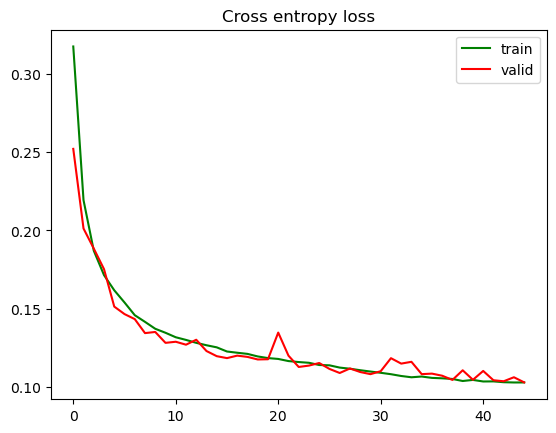

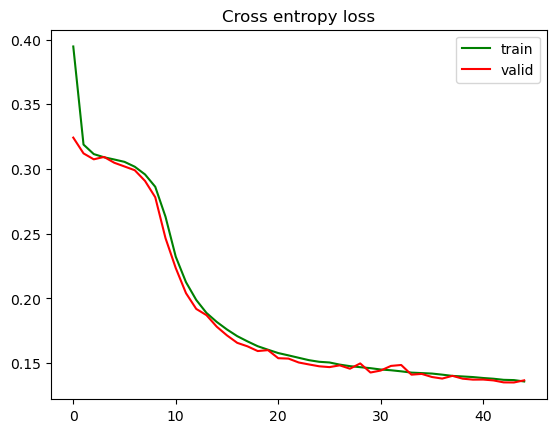

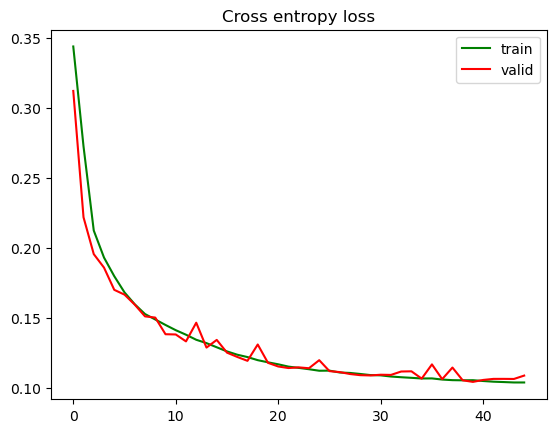

In [18]:
param_grid = {
    'architecture': [
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 16, 'activation': nn.ReLU},
                {'out_units': 16, 'activation': nn.ReLU}
            ],
            'output_units': 2
        },
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 16, 'activation': nn.Sigmoid},
                {'out_units': 16, 'activation': nn.Sigmoid}
            ],
            'output_units': 2
        },
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 16, 'activation': nn.Tanh},
                {'out_units': 16, 'activation': nn.Tanh}
            ],
            'output_units': 2
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [45]
}

best_model, best_accuracy = hyperparameter_search(train_loader, val_loader, test_loader, param_grid, device)
print(f"Best parameters: {best_model.parameters}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

A melhor acurácia foi com a ReLU (95.35%).

### Testes de arquitetura

Nesse primeiro teste, estamos utilizando 2 hidden layers, variando a quantidade de neurônios (32, 64, ou 128).

Parameter set 1/3
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 32, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'out_units': 32, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.113418
Valid. loss: 0.118198

Train loss: 0.10494
Valid. loss: 0.109489

Train loss: 0.100379
Valid. loss: 0.105165

Train loss: 0.097803
Valid. loss: 0.104945

Train loss: 0.09473
Valid. loss: 0.104321

              precision    recall  f1-score   support

           0     0.9238    0.9840    0.9530     14573
           1     0.9777    0.8963    0.9352     11403

    accuracy                         0.9455     25976
   macro avg     0.9508    0.9401    0.9441     25976
weighted avg     0.9475    0.9455    0.9452     25976

Parameter set 2/3
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.110877
Valid. loss: 0.12103

Train loss: 0.09942
Valid. loss: 0.102978

Train loss: 0.093421
Valid. loss: 0.101134

Train loss: 0.087515
Valid. loss: 0.100882

Train loss: 0.08417
Valid. loss: 0.099531

              precision    recall  f1-score   support

           0     0.9426    0.9753    0.9587     14573
           1     0.9670    0.9241    0.9450     11403

    accuracy                         0.9528     25976
   macro avg     0.9548    0.9497    0.9518     25976
weighted avg     0.9533    0.9528    0.9527     25976

Parameter set 3/3
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.102872
Valid. loss: 0.104198

Train loss: 0.092127
Valid. loss: 0.099366

Train loss: 0.083802
Valid. loss: 0.100616

Train loss: 0.077917
Valid. loss: 0.102679

Train loss: 0.071899
Valid. loss: 0.100822

              precision    recall  f1-score   support

           0     0.9258    0.9728    0.9487     14573
           1     0.9629    0.9004    0.9306     11403

    accuracy                         0.9410     25976
   macro avg     0.9443    0.9366    0.9397     25976
weighted avg     0.9421    0.9410    0.9408     25976

Best parameters: <bound method Module.parameters of MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=25, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)>
Best validation accuracy: 0.9528


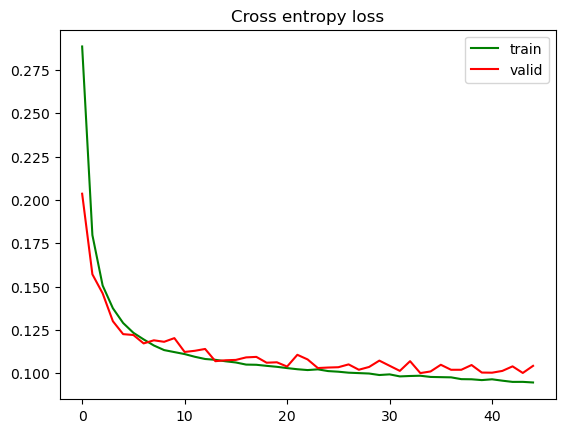

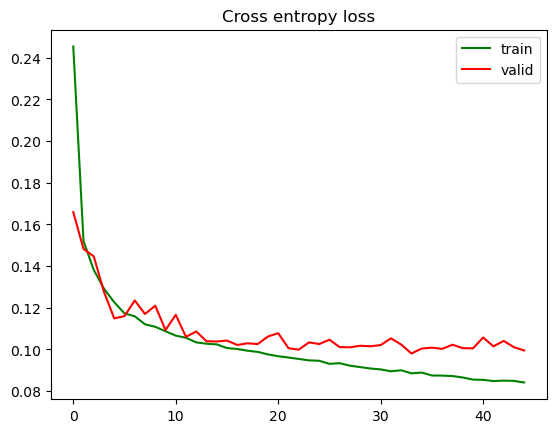

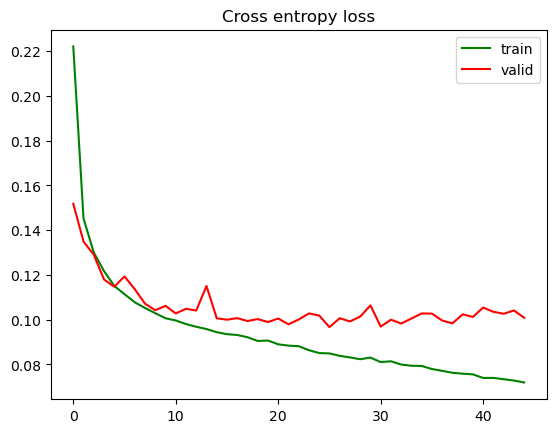

In [19]:
param_grid = {
    'architecture': [
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 32, 'activation': nn.ReLU},
                {'out_units': 32, 'activation': nn.ReLU}
            ],
            'output_units': 2
        },
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 64, 'activation': nn.ReLU},
                {'out_units': 64, 'activation': nn.ReLU}
            ],
            'output_units': 2
        },
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU},
                {'out_units': 128, 'activation': nn.ReLU}
            ],
            'output_units': 2
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [45]
}

best_model, best_accuracy = hyperparameter_search(train_loader, val_loader, test_loader, param_grid, device)
print(f"Best parameters: {best_model.parameters}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

A melhor acurácia foi com 64 unidades (95.28%). Observa-se um aumento da loss de validação com 128 neurônios, o que indica que talvez esteja tendo algum tipo de overfitting.

### Testando técnicas de regularização: Dropout

Aqui testamos algumas arquiteturas ainda mais complexas (todas com 2 hidden layers, com 64, 128, 256 ou 512 unidades), dessa vez utilizando um dropout com 30% de chance, a fim de atenuar o overfitting.

Parameter set 1/4
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.130896
Valid. loss: 0.112999

Train loss: 0.118481
Valid. loss: 0.104473

Train loss: 0.113356
Valid. loss: 0.106863

Train loss: 0.112065
Valid. loss: 0.102741

Train loss: 0.10975
Valid. loss: 0.09851

              precision    recall  f1-score   support

           0     0.9252    0.9782    0.9509     14573
           1     0.9699    0.8989    0.9330     11403

    accuracy                         0.9434     25976
   macro avg     0.9475    0.9385    0.9420     25976
weighted avg     0.9448    0.9434    0.9431     25976

Parameter set 2/4
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.117253
Valid. loss: 0.107057

Train loss: 0.108501
Valid. loss: 0.101031

Train loss: 0.104389
Valid. loss: 0.096507

Train loss: 0.10083
Valid. loss: 0.096364

Train loss: 0.09823
Valid. loss: 0.094179

              precision    recall  f1-score   support

           0     0.9262    0.9798    0.9523     14573
           1     0.9722    0.9003    0.9348     11403

    accuracy                         0.9449     25976
   macro avg     0.9492    0.9401    0.9436     25976
weighted avg     0.9464    0.9449    0.9446     25976

Parameter set 3/4
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.112597
Valid. loss: 0.100688

Train loss: 0.103216
Valid. loss: 0.096328

Train loss: 0.098504
Valid. loss: 0.095972

Train loss: 0.094857
Valid. loss: 0.092818

Train loss: 0.092751
Valid. loss: 0.090045

              precision    recall  f1-score   support

           0     0.9314    0.9795    0.9548     14573
           1     0.9719    0.9077    0.9387     11403

    accuracy                         0.9480     25976
   macro avg     0.9516    0.9436    0.9468     25976
weighted avg     0.9492    0.9480    0.9478     25976

Parameter set 4/4
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.108951
Valid. loss: 0.104214

Train loss: 0.100661
Valid. loss: 0.094405

Train loss: 0.096058
Valid. loss: 0.091776

Train loss: 0.092419
Valid. loss: 0.095393

Train loss: 0.088963
Valid. loss: 0.092259

              precision    recall  f1-score   support

           0     0.9191    0.9813    0.9492     14573
           1     0.9739    0.8896    0.9298     11403

    accuracy                         0.9411     25976
   macro avg     0.9465    0.9355    0.9395     25976
weighted avg     0.9431    0.9411    0.9407     25976

Best parameters: <bound method Module.parameters of MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)>
Best validation accuracy: 0.9480


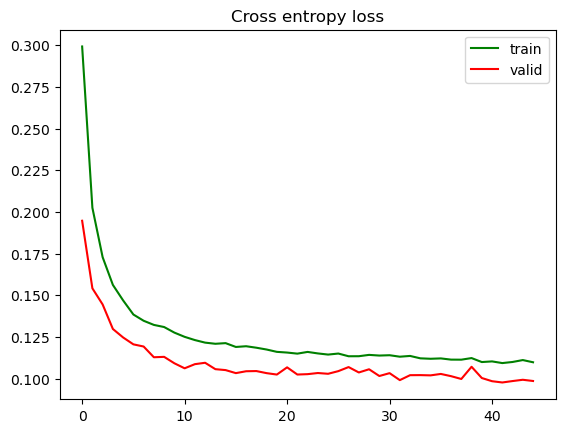

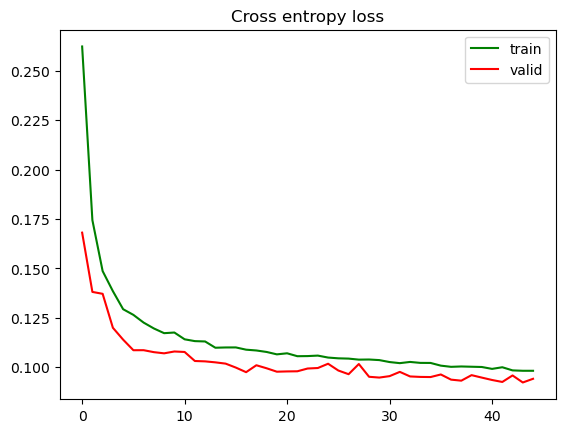

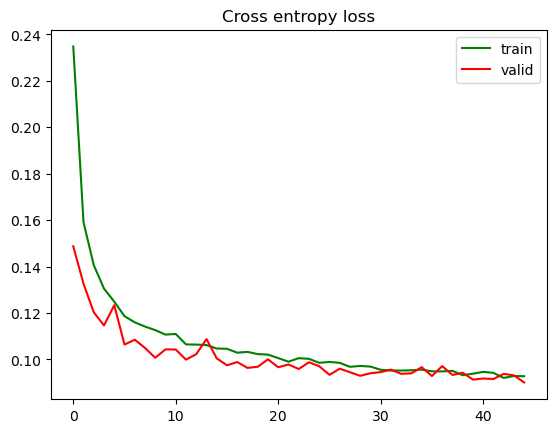

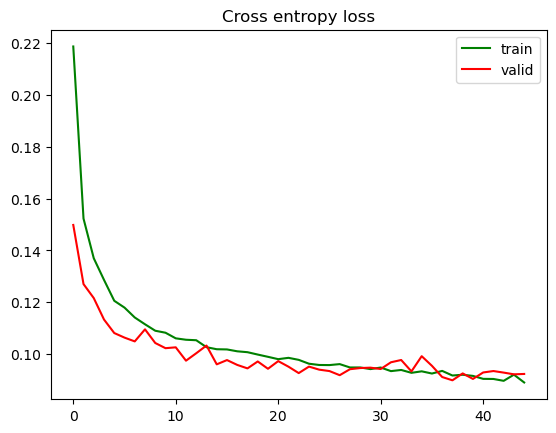

In [20]:
param_grid = {
    'architecture': [
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 2
        },
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 2
        },
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 2
        },
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 512, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 512, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 2
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [45]
}

best_model, best_accuracy = hyperparameter_search(train_loader, val_loader, test_loader, param_grid, device)
print(f"Best parameters: {best_model.parameters}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

A melhor acurácia foi com as 2 hidden layers com 256 neurônios cada, com uma acurácia de 94.80%, o que ainda é menor que a acurácia com as 2 hidden layers com 64 unidades, sem dropout. Talvez tenha tido uma diminuição da acurácia por conta do dropout, mas esse dropout nos permite explorar arquiteturas ainda mais complexas, para possivelmente tentarmos obter uma acurácia melhor, tentaremos fazer isso a seguir.

Parameter set 1/4
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.116386
Valid. loss: 0.10148

Train loss: 0.106599
Valid. loss: 0.099453

Train loss: 0.103674
Valid. loss: 0.095679

Train loss: 0.101278
Valid. loss: 0.097025

Train loss: 0.096704
Valid. loss: 0.091889

              precision    recall  f1-score   support

           0     0.9311    0.9805    0.9551     14573
           1     0.9733    0.9072    0.9391     11403

    accuracy                         0.9483     25976
   macro avg     0.9522    0.9439    0.9471     25976
weighted avg     0.9496    0.9483    0.9481     25976

Parameter set 2/4
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.112456
Valid. loss: 0.101425

Train loss: 0.104353
Valid. loss: 0.097457

Train loss: 0.099988
Valid. loss: 0.096365

Train loss: 0.096508
Valid. loss: 0.090434

Train loss: 0.095043
Valid. loss: 0.095061

              precision    recall  f1-score   support

           0     0.9251    0.9837    0.9535     14573
           1     0.9773    0.8983    0.9361     11403

    accuracy                         0.9462     25976
   macro avg     0.9512    0.9410    0.9448     25976
weighted avg     0.9480    0.9462    0.9459     25976

Parameter set 3/4
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 1024, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropo

/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.114582
Valid. loss: 0.104462

Train loss: 0.10859
Valid. loss: 0.097785

Train loss: 0.105428
Valid. loss: 0.095464

Train loss: 0.104897
Valid. loss: 0.110093

Train loss: 0.103965
Valid. loss: 0.09715

              precision    recall  f1-score   support

           0     0.9347    0.9808    0.9572     14573
           1     0.9738    0.9124    0.9421     11403

    accuracy                         0.9508     25976
   macro avg     0.9542    0.9466    0.9496     25976
weighted avg     0.9518    0.9508    0.9506     25976

Parameter set 4/4
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout'

/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_10966/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.115824
Valid. loss: 0.108354

Train loss: 0.109522
Valid. loss: 0.100078

Train loss: 0.105575
Valid. loss: 0.096093

Train loss: 0.101564
Valid. loss: 0.097536

Train loss: 0.100135
Valid. loss: 0.096406

              precision    recall  f1-score   support

           0     0.9195    0.9850    0.9511     14573
           1     0.9789    0.8899    0.9322     11403

    accuracy                         0.9432     25976
   macro avg     0.9492    0.9374    0.9417     25976
weighted avg     0.9456    0.9432    0.9428     25976



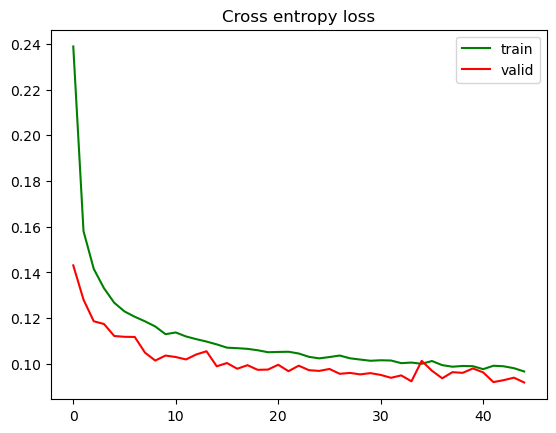

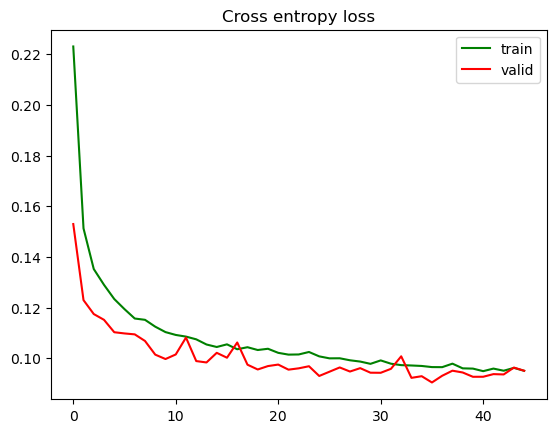

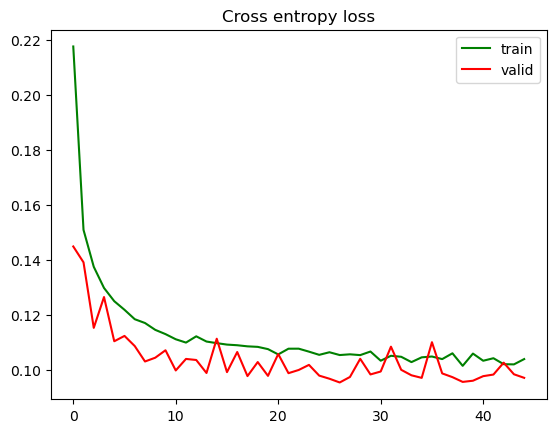

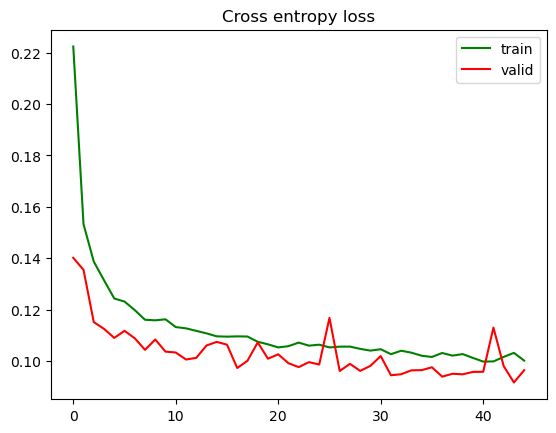

In [25]:
param_grid = {
    'architecture': [
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 2
        },
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 512, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 2
        },
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 1024, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 512, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 2
        },
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 512, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 512, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 2
        },
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [45]
}

best_m, best_ac = hyperparameter_search(train_loader, val_loader, test_loader, param_grid, device)

Parameter set 1/1
Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 1024, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 2}, 'epochs': 45, 'learning_rate': 0.001, 'optimizer': 'Adam'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_18155/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


Train loss: 0.115337
Valid. loss: 0.10388

Train loss: 0.107707
Valid. loss: 0.099012

Train loss: 0.104239
Valid. loss: 0.103021

Train loss: 0.104135
Valid. loss: 0.095283

Train loss: 0.102375
Valid. loss: 0.094826

              precision    recall  f1-score   support

           0     0.9457    0.9732    0.9592     14573
           1     0.9644    0.9285    0.9461     11403

    accuracy                         0.9536     25976
   macro avg     0.9550    0.9508    0.9527     25976
weighted avg     0.9539    0.9536    0.9535     25976



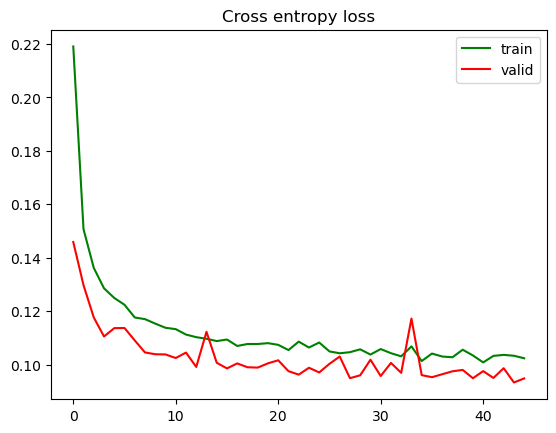

In [14]:
param_grid = {
    'architecture': [
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 1024, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 512, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 2
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [45]
}

best_m, best_ac = hyperparameter_search(train_loader, val_loader, test_loader, param_grid, device)

Arquitetura final:

In [15]:
print(f"Best parameters: {best_m.parameters}")
print(f"Best validation accuracy: {best_ac:.4f}")

Best parameters: <bound method Module.parameters of MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=25, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
  )
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)>
Best validation accuracy: 0.9536


### Métricas

In [54]:
def test_wrongs(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        instances = instances.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        corrects = preds == labels

        total_corrects += corrects.sum().item()
        total_n += len(instances)

        all_probs.append(probabilities.cpu())
        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())

    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()
    probs = torch.cat(all_probs).cpu()[:, 1]  # Get probabilities for the positive class (class 1)

    return (preds, targets, probs)

In [55]:
all_preds, all_targets, probs = test_wrongs(best_m, test_loader, device)

/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_18155/4006685046.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('int64')


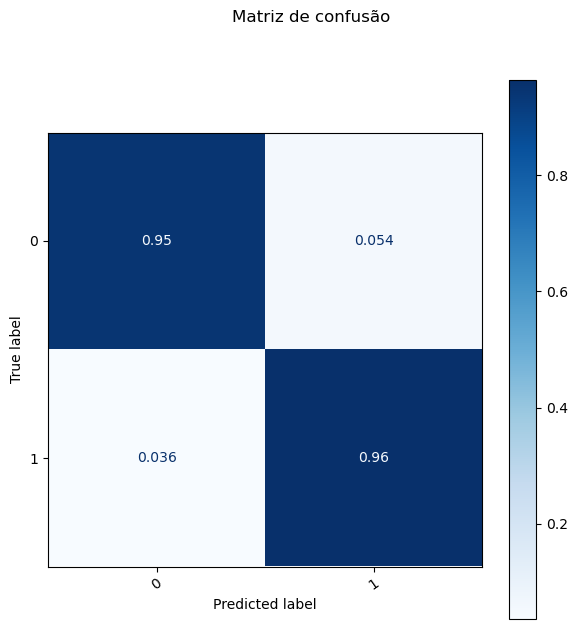

In [21]:
# Compute the confusion matrix
cm = confusion_matrix(all_preds, all_targets)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

# Display the normalized confusion matrix
cm_display = ConfusionMatrixDisplay(cm_normalized, display_labels=[0, 1])
cm_display.plot(ax=ax, xticks_rotation=35.0, cmap='Blues')
plt.show()

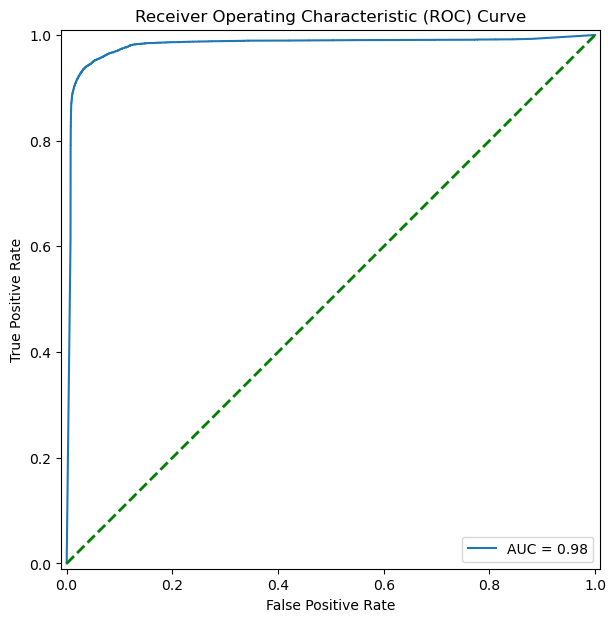

In [64]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_targets, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax)
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')

ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()

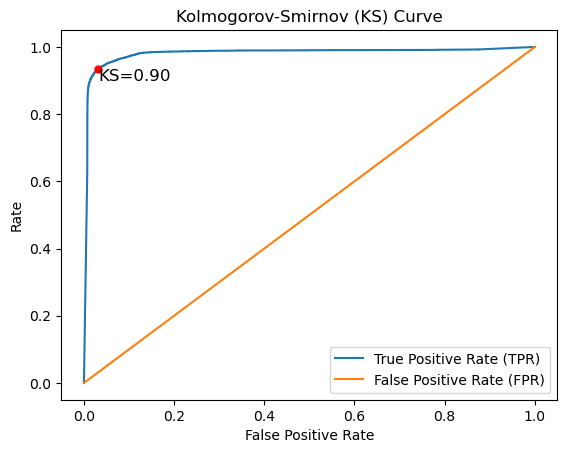

KS Statistic: 0.90


In [66]:
ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)

plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='top')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")

In [67]:
torch.save(best_m.state_dict(), 'best_model.pth')